# L2 - Contextualized Token Embeddings

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

In [50]:
from sentence_transformers import CrossEncoder  
import torch 

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code> file:</b> To access <code>requirements.txt</code> for this notebook, 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

In [51]:
model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512,   
                     default_activation_function=torch.nn.Sigmoid())  

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## GloVe word embeddings

In [10]:
import gensim.downloader as api
word_vectors = api.load('glove-wiki-gigaword-100')
#word_vectors = api.load('word2vec-google-news-300')

In [13]:
word_vectors['brazil'].shape

(100,)

In [5]:
word_vectors['king'][:20]

array([-0.32307 , -0.87616 ,  0.21977 ,  0.25268 ,  0.22976 ,  0.7388  ,
       -0.37954 , -0.35307 , -0.84369 , -1.1113  , -0.30266 ,  0.33178 ,
       -0.25113 ,  0.30448 , -0.077491, -0.89815 ,  0.092496, -1.1407  ,
       -0.58324 ,  0.66869 ], dtype=float32)

In [14]:
# Words to visualize
words = ["brazil", "argentina", "australia", "saturn", "soccer", 
         "earth", "boat", "beach", "sadness", "happiness", "sweden"]

# Get word vectors
vectors = np.array([word_vectors[word] for word in words])

In [15]:
# Reduce dimensions using PCA
pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(vectors)

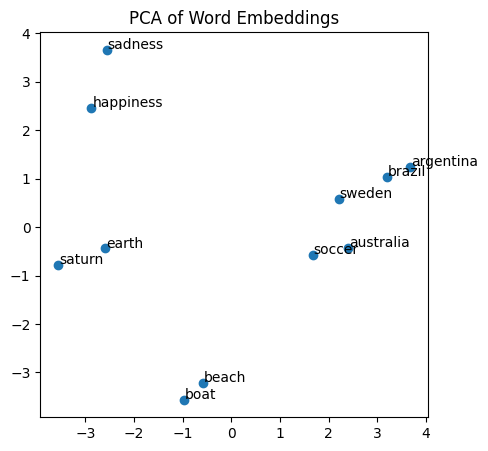

In [16]:
# Plotting
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.scatter(vectors_pca[:, 0], vectors_pca[:, 1])
for i, word in enumerate(words):
    axes.annotate(word, (vectors_pca[i, 0]+.02, vectors_pca[i, 1]+.02))
axes.set_title('PCA of Word Embeddings')
plt.show()

## Word2Vec algebra

In [39]:
result = word_vectors.most_similar(positive=['soccer', 'volley'], 
                                   negative=['foot'], topn=1)

# Output the result
print(f"""
    The word closest to is: '{result[0][0]}' 
    with a similarity score of {result[0][1]}""")


    The word closest to is: 'football' 
    with a similarity score of 0.5529492497444153


## GloVe vs BERT: words in context

In [33]:
tokenizer = BertTokenizer.from_pretrained('./models/bert-base-uncased')
model = BertModel.from_pretrained('./models/bert-base-uncased')

# Function to get BERT embeddings
def get_bert_embeddings(sentence, word):
    inputs = tokenizer(sentence, return_tensors='pt')
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    word_tokens = tokenizer.tokenize(sentence)
    word_index = word_tokens.index(word)
    word_embedding = last_hidden_states[0, word_index + 1, :]  # +1 to account for [CLS] token
    return word_embedding

In [44]:
sentence1 = "they always eat turkey in thanksgiving."
sentence2 = "i have a neighbor that lived in turkey for a year"

word = "turkey"

bert_embedding1 = get_bert_embeddings(sentence1, word).detach().numpy()
bert_embedding2 = get_bert_embeddings(sentence2, word).detach().numpy()
word_embedding = word_vectors[word]

In [45]:
print("BERT Embedding for 'turkey' in sentence 1:", bert_embedding1[:5])
print("BERT Embedding for 'turkey' in sentence 2:", bert_embedding2[:5])
print("GloVe Embedding for 'turkey':", word_embedding[:5])

bert_similarity = cosine_similarity([bert_embedding1], [bert_embedding2])[0][0]
word_embedding_similarity = cosine_similarity([word_embedding], [word_embedding])[0][0]

print()
print(f"Cosine Similarity between BERT embeddings in different contexts: {bert_similarity}")
print(f"Cosine Similarity between GloVe embeddings: {word_embedding_similarity}")


BERT Embedding for 'turkey' in sentence 1: [ 0.5298779   0.8777523   0.37118292 -0.22158045 -0.28838712]
BERT Embedding for 'turkey' in sentence 2: [ 0.00960002  0.04355409  0.2879686  -0.3441911  -0.21316743]
GloVe Embedding for 'turkey': [-0.24425  0.48891  0.21577  0.22411  0.21411]

Cosine Similarity between BERT embeddings in different contexts: 0.5901823043823242
Cosine Similarity between GloVe embeddings: 0.9999998807907104


## Cross Encoder

In [52]:

model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512, 
                     default_activation_function=torch.nn.Sigmoid())

In [73]:
question = "What's the color of my eyes?"
# Define sentences to compare
answers = [
    "the color of my eyes is black",
    "the color of my eyes is white",
    "the color of my eyes is golden",
    "the color of my eyes is purple"
]

In [74]:
scores = model.predict([(question, answers[0]), (question, answers[1]),
                        (question, answers[2]),(question, answers[3])])
print(scores)
most_relevant_idx = torch.argmax(torch.tensor(scores)).item()
print(f"The most relevant passage is: {answers[most_relevant_idx]}")

[0.9997831 0.9998215 0.9997538 0.9996941]
The most relevant passage is: the color of my eyes is white
